In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid

%matplotlib inline

In [2]:
df = pd.read_csv('data/zillow_data.csv')
lumber = pd.read_csv('data/plywood_prices.csv')
concrete = pd.read_csv('data/concrete_prices.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
lumber.rename({'WPU083': 'plywood prices', 'DATE': 'time'}, axis=1, inplace=True)
lumber

,time,plywood prices
0,2003-12-01,192.1
1,2004-01-01,174.4
2,2004-02-01,202.5
3,2004-03-01,218.5
4,2004-04-01,222.6
...,...,...
168,2017-12-01,218.1
169,2018-01-01,219.8
170,2018-02-01,227.9
171,2018-03-01,236.5


In [4]:
concrete.rename({'PCU32733273': 'concrete prices', 'DATE' : 'time'}, axis = 1, inplace = True)
concrete

,time,concrete prices
0,2003-12-01,100.0
1,2004-01-01,100.9
2,2004-02-01,101.7
3,2004-03-01,101.7
4,2004-04-01,102.4
...,...,...
168,2017-12-01,164.3
169,2018-01-01,165.8
170,2018-02-01,166.1
171,2018-03-01,168.9


In [5]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [6]:
def melt_data(df, compress = False):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    
    If compress is True will compress data to only the value column.
    """
    if compress == True:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted.groupby('time').aggregate({'value':'mean'})
    else:
        melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                      'Metro', 'CountyName'], var_name='time')
        melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
        melted = melted.dropna(subset=['value'])
        return melted

In [7]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Takes in the y_true values and the y_pred and will
    return the mean absolute error as a percent
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [47]:
def plot_series(df, name = None, window = None, X = None, y = None, x_label = None, y_label = None):
    '''
    Will plot dataframe, rolling mean, rolling std of a given dataframe
    
    Parameters
    ------------
    df : The dataframe you with to plot
    name : The name of the plot
    window : The window of the rolling values
    X = length of the df
    y = height of the df
    x_label = The X-axis label
    y_label = The y-axis label
    
    '''
    df_mean = df.rolling(window=window).mean()
    df_std = df.rolling(window=window).std()

    fig, ax = plt.subplots(figsize = (X,y))

    orig = plt.plot(df, label = 'Original')
    mean = plt.plot(df_mean, label = 'Rolling Mean')
    std = plt.plot(df_std, label = 'Rolling Std')
    plt.title(name)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show();

In [8]:
df_melt = melt_data(df)
df_melt.head()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
0,60657,84654,1,Chicago,IL,Chicago,Cook,1996-04-01,334200.0
1,75070,90668,2,McKinney,TX,Dallas-Fort Worth,Collin,1996-04-01,235700.0
2,77494,91982,3,Katy,TX,Houston,Harris,1996-04-01,210400.0
3,60614,84616,4,Chicago,IL,Chicago,Cook,1996-04-01,498100.0
4,79936,93144,5,El Paso,TX,El Paso,El Paso,1996-04-01,77300.0


In [9]:
df_melt.tail()

,RegionName,RegionID,SizeRank,City,State,Metro,CountyName,time,value
3901590,1338,58333,14719,Ashfield,MA,Greenfield Town,Franklin,2018-04-01,209300.0
3901591,3293,59107,14720,Woodstock,NH,Claremont,Grafton,2018-04-01,225800.0
3901592,40404,75672,14721,Berea,KY,Richmond,Madison,2018-04-01,133400.0
3901593,81225,93733,14722,Mount Crested Butte,CO,NaN,Gunnison,2018-04-01,664400.0
3901594,89155,95851,14723,Mesquite,NV,Las Vegas,Clark,2018-04-01,357200.0


In [10]:
df_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3744704 entries, 0 to 3901594
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   RegionName  int64         
 1   RegionID    int64         
 2   SizeRank    int64         
 3   City        object        
 4   State       object        
 5   Metro       object        
 6   CountyName  object        
 7   time        datetime64[ns]
 8   value       float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 285.7+ MB


In [11]:
df_melt.time.min(), df_melt.time.max()

(Timestamp('1996-04-01 00:00:00'), Timestamp('2018-04-01 00:00:00'))

#### Melting the data so that I only have values. WIll then merge the plywood and concrete prices with the values.

In [12]:
melted_df= melt_data(df, compress=True)
melted_df = melted_df[melted_df.index >= '2003-12-01']

In [13]:
melted_df

,value
time,
2003-12-01,204228.359290
2004-01-01,207492.620700
2004-02-01,209244.217982
2004-03-01,211168.039896
2004-04-01,213296.509107
...,...
2017-12-01,281095.320247
2018-01-01,282657.060382
2018-02-01,284368.688447


In [14]:
try:
    lumber.set_index('time', inplace=True)
except:
    pass
lumber

,plywood prices
time,
2003-12-01,192.1
2004-01-01,174.4
2004-02-01,202.5
2004-03-01,218.5
2004-04-01,222.6
...,...
2017-12-01,218.1
2018-01-01,219.8
2018-02-01,227.9


In [15]:
try:
    concrete.set_index('time', inplace=True)
except:
    pass
concrete

,concrete prices
time,
2003-12-01,100.0
2004-01-01,100.9
2004-02-01,101.7
2004-03-01,101.7
2004-04-01,102.4
...,...
2017-12-01,164.3
2018-01-01,165.8
2018-02-01,166.1


In [16]:
try:
    con_lum = pd.concat([concrete, lumber], axis=1)
except:
    pass
con_lum.sample(50)

,concrete prices,plywood prices
time,,
2008-01-01,133.9,174.3
2018-01-01,165.8,219.8
2016-10-01,159.3,191.0
2012-09-01,137.9,197.2
2010-09-01,134.9,174.1
2012-02-01,136.8,180.7
2004-04-01,102.4,222.6
2004-05-01,103.0,224.4
2005-01-01,110.3,187.0


In [17]:
try:
    con_lum.index = pd.to_datetime(con_lum.index)
except:
    pass
con_lum

,concrete prices,plywood prices
time,,
2003-12-01,100.0,192.1
2004-01-01,100.9,174.4
2004-02-01,101.7,202.5
2004-03-01,101.7,218.5
2004-04-01,102.4,222.6
...,...,...
2017-12-01,164.3,218.1
2018-01-01,165.8,219.8
2018-02-01,166.1,227.9


In [44]:
len(con_lum.index) == len(melted_df.index)

True

In [19]:
final_df = pd.concat([con_lum, melted_df], axis=1)
final_df

,concrete prices,plywood prices,value
time,,,
2003-12-01,100.0,192.1,204228.359290
2004-01-01,100.9,174.4,207492.620700
2004-02-01,101.7,202.5,209244.217982
2004-03-01,101.7,218.5,211168.039896
2004-04-01,102.4,222.6,213296.509107
...,...,...,...
2017-12-01,164.3,218.1,281095.320247
2018-01-01,165.8,219.8,282657.060382
2018-02-01,166.1,227.9,284368.688447


# TIme Series Analysis

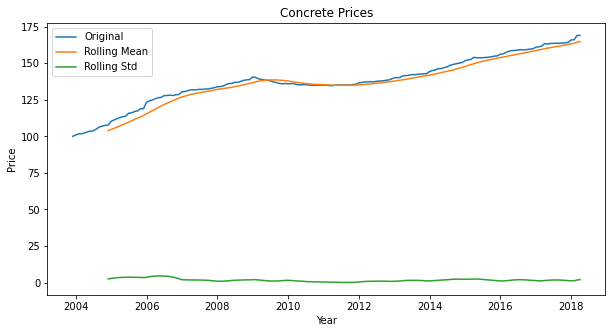

In [46]:
concrete_prices = final_df[['concrete prices']]
plot_series(concrete_prices, name = 'Concrete Prices', window=13, X = 10, y = 5, x_label= 'Year', y_label='Price')